In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
from ase.io import read, write
from ase import Atoms
from ase.neighborlist import NeighborList
from scipy.spatial.distance import cdist
from tqdm import tqdm
from matplotlib import cm

In [2]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
surface_name_dict={"anatase-100":"anatase (100)",
                    "anatase-101":"anatase (101)",
                    "anatase-110": "anatase (110)",
                    "rutile-001": "rutile (001)",
                     "rutile-011": "rutile (011)", 
                    "rutile-100": "rutile (100)",
                    "rutile-110": "rutile (110)",
                   "rutile-110-nd-0-10l": "rutile (110)"}

In [5]:
system_now = 'anatase-100-nd-0'

nhydrogen = 128*2

In [6]:
system_ref = 'anatase-101-nd-0' # always use this
with open('anatase-101-nd-0-h-dis-env.npy', 'rb') as f:
    h_dis_all_ref = np.load(f)

In [7]:
colvar = np.genfromtxt(system_now+'/COLVAR')[1000:10000:10] # consistent with the gen of features
tt = 330 #K
kbt = 0.008314*tt # in kj/mol

print(len(colvar))
sys_weights = np.exp((colvar[:,2]+colvar[:,3])/kbt)

900


In [9]:
h_weights = np.ones((len(sys_weights),nhydrogen))
for i in range(len(sys_weights)):
    h_weights[i,:] *= sys_weights[i]

In [10]:
with open(system_now+'-h-dis-env.npy', 'rb') as f:
    h_dis_all = np.load(f)
    h_env_all = np.load(f)

In [11]:
%matplotlib inline 

In [12]:
from asaplib.reducedim import Dimension_Reducers
from asaplib.plot import Plotters as asapPlotters

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/umap_learn-0.4.3-py3.7.egg/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [14]:
reduce_dict = {}
"""
reduce_dict['pca'] = {
    "type": 'PCA',
    'parameter':{
        "n_components": 4}
}
"""
reduce_dict['kpca'] = {
    "type": 'SPARSE_KPCA',
    'parameter':{
        "n_components": 2,
        "n_sparse": 200, # no sparsification
        "kernel": {"first_kernel": {"type": 'cosine'}}
    }
}

dreducer = Dimension_Reducers(reduce_dict)

#hcoord_ref = np.reshape(h_dis_all_ref,(-1,11))
hcoord_ref = np.reshape(h_dis_all_ref,(-1,np.shape(h_dis_all_ref)[-1]))
hcoord_now = np.reshape(h_dis_all,(-1,np.shape(h_dis_all)[-1]))

#proj = dreducer.fit_transform(hcoord_now[:,[1,2,3,5,6,8,9,10]])

Using kernel PCA (sparsified) ...


In [15]:
dreducer.fit(hcoord_ref[:,[1,2,3,5,6,8,9,10,12]])
proj = dreducer.transform(hcoord_now[:,[1,2,3,5,6,8,9,10,12]])

In [16]:
# reshape

h_proj = np.reshape( proj[:,[0,1]],(-1,nhydrogen,2))
print(np.shape(h_proj))

stride = 1
h_proj_sparse = h_proj[::stride,:,:]
np.shape(h_proj_sparse)

h_proj_sparse_all = np.reshape(h_proj_sparse[1:,:,:],(-1,2))

(900, 256, 2)


In [17]:
# classify

cls_labels= ['H$_2$O$^{(> 1)}$','H-O$_t$','HO-Ti','H$_2$O-Ti','H$_2$O$^{(1)}$']

cls = np.zeros(len(hcoord_now))
for i,hh in enumerate(hcoord_now):
    if hh[3] >= 5: 
        cls[i] = 0 # in the bulk
    elif hh[3] < 1.25 and hh[2] > 1.6:
        cls[i] = 1 # H on O(TiO2)
    elif hh[2] > 1.85 and hh[5] < 3: # OH on Ti
        cls[i] = 2 # OH on Ti
    elif hh[5] < 3:
        cls[i] = 3 # H2O on Ti
    else:
        cls[i] = 4 # H2O close to slab but not on Ti
        
cls =  np.reshape( cls,(-1,nhydrogen))
np.shape(cls)

(900, 256)

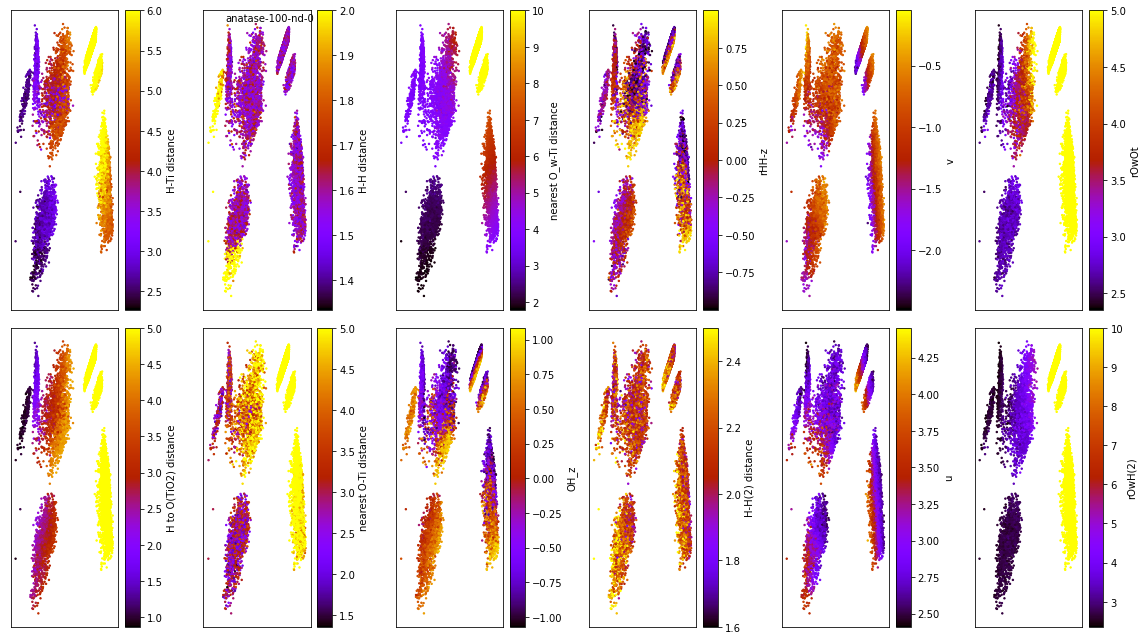

In [21]:
    # the distance vector array: 
    # 0:central_atom, 1:rHTi, 2:rHH, 3:rHO_TiO2, 4:rOTi, 5:rOwTi, 6:r_O_1_z, 7:rHH_z, 8:v, 9:mu, 10:rOO, 11:rHH2
fig, axs = plt.subplots(2, 6, figsize=(16,9))

ax = axs[0,0]
plotcolor = hcoord_now[::10,1]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=6)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H-Ti distance', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[0,1]
plotcolor = hcoord_now[::10,2]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=2)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H-H distance', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.text(.2, .99, system_now, ha='left', va='top', transform=ax.transAxes)


ax = axs[1,0]
plotcolor = hcoord_now[::10,3]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H to O(TiO2) distance', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[1,1]
plotcolor = hcoord_now[::10,4]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('nearest O-Ti distance', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[0,2]
plotcolor = hcoord_now[::10,5]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('nearest O_w-Ti distance', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[1,2]
plotcolor = hcoord_now[::10,6]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('OH_z', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[0,3]
plotcolor = hcoord_now[::10,7]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('rHH-z', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[1,3]
plotcolor = hcoord_now[::10,11]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=2.5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H-H(2) distance', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])


ax = axs[0,4]
plotcolor = hcoord_now[::10,8]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('v', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[1,4]
plotcolor = hcoord_now[::10,9]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('u', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax = axs[0, 5]
plotcolor = hcoord_now[::10,12]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('rOwOt', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])


ax = axs[1, 5]
plotcolor = hcoord_now[::10,-1]
sc = ax.scatter(proj[::10,0], proj[::10,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('rOwH(2)', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])


rx = ax.get_xlim()
ry = ax.get_ylim()

fig.tight_layout()
plt.show()

#fig.savefig(system_now+'-H-analysis.png',dpi=100,rasterized=True)

In [22]:
# build FES

    
H, xedges, yedges = np.histogram2d(proj[:,0], proj[:,1], 
                                   range=[[rx[0], rx[1]], [ry[0], ry[1]]],
                                   weights = h_weights.flatten(),
                                   bins=80)

In [23]:
FES = -kbt*np.log(H.T)
FES -= np.amin(FES)

/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


/Users/tc/miniconda/envs/chicken/lib/python3.7/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later


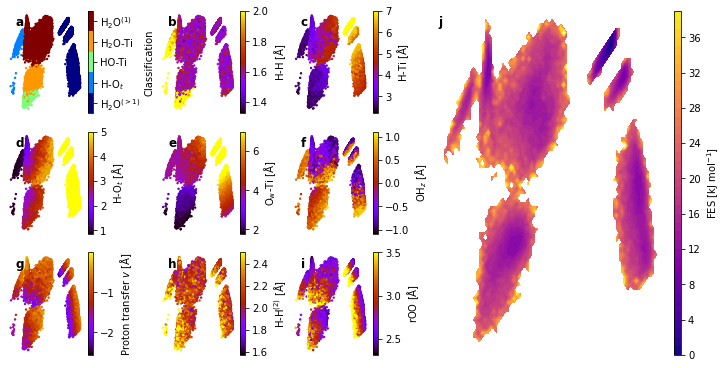

In [25]:
fig = plt.figure(constrained_layout=True,figsize=(10,5))
ax_dict = fig.subplot_mosaic(
    [
        ["a", "b","c", "j","j","j"],
        ["d", "e", "f","j","j","j"],
        ["g", "h", "i","j","j","j"],
    ],
)

ax=ax_dict["j"]
im = ax.contourf((xedges[1:]+xedges[:-1])/2., 
              (yedges[1:]+yedges[:-1])/2. ,
             FES, levels=np.arange(0,40),
             vmin=0, vmax=40, cmap='plasma') #cmap='coolwarm')
cbar = plt.colorbar(im, ax=ax,aspect=50)
cbar.set_label('FES [kJ mol$^{-1}$]', rotation=90)



ax = ax_dict["a"]
plotcolor = cls.flatten()[::1]
cmap = cm.get_cmap('jet', 5)
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap=cmap, s=2, vmin=-0.5, vmax=4.5)
#cbaxes = ax.inset_axes([0.0, 1.1, 1.0, 0.02])
#cbar= plt.colorbar(sc, cax=cbaxes, ticks=[0, 1, 2, 3, 4], orientation='horizontal')
cbar = plt.colorbar(sc, ax=ax, ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(cls_labels)
#cbar.set_label('Classification',labelpad=-3) #, rotation=90)
cbar.set_label('Classification', rotation=90)




ax = ax_dict["b"]
plotcolor = hcoord_now[::1,2]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=2)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H-H [$\mathrm{\AA}$]', rotation=90)

ax = ax_dict["c"]
plotcolor = hcoord_now[::1,1]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=7)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H-Ti [$\mathrm{\AA}$]', rotation=90)

ax = ax_dict["d"]
plotcolor = hcoord_now[::1,3]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H-O$_t$ [$\mathrm{\AA}$]', rotation=90)

ax = ax_dict["e"]
plotcolor = hcoord_now[::1,5]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=7)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('O$_\mathrm{w}$-Ti [$\mathrm{\AA}$]', rotation=90)

ax = ax_dict["f"]
plotcolor = hcoord_now[::1,6]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('OH$_z$ [$\mathrm{\AA}$]', rotation=90)

ax = ax_dict["g"]
plotcolor = hcoord_now[::1,8]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=None)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Proton transfer $v$ [$\mathrm{\AA}$]', rotation=90)


ax = ax_dict["h"]
plotcolor = hcoord_now[::1,11]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=2.5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('H-H$^{(2)}$ [$\mathrm{\AA}$]', rotation=90)

ax = ax_dict["i"]
plotcolor = hcoord_now[::1,10]
sc = ax.scatter(proj[::1,0], proj[::1,1], c=plotcolor, cmap='gnuplot', s=2, vmin=None, vmax=3.5)
cbar = plt.colorbar(sc, ax=ax,ticks=[2, 2.5, 3, 3.5])
cbar.set_label('rOO [$\mathrm{\AA}$]', rotation=90)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#fig.tight_layout()

#identify_axes(ax_dict)

for label,ax in ax_dict.items():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
import matplotlib.transforms as mtransforms

for label, ax in ax_dict.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-0.02, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', weight='bold', verticalalignment='top')

fig.savefig(system_now+'-H-analysis.png',dpi=100,rasterized=True)